# Workflow of Implementing PDF to Audio Converter

1. PDF Parsing
2. Implement OCR to extract text from PDF in JSON format
3. Data Preprocessing
4. Feature Extraction
   1. Extracting text features - word frequency, sentence length, presence of special characters, etc.
   2. Extracting layout features - font size, font type, font color, position (x, y), size (width, height), aspect ratio, etc.
5. Machine Learning Model
6. Model Evaluation
7. Text to Speech Conversion
8. Audio File Generation
9. Audio File Postprocessing
10. Final Output


In [2]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [9]:
import os
import json
import fitz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
import pyttsx3

In [10]:
# PDF Parsing
def pdf_parsing(pdf_file):
    pdf = fitz.open(pdf_file)
    text = ""
    for page in pdf:
        text += page.get_text()
    pdf.close()
    return text

In [11]:
# Implement OCR to extract text from PDF in JSON format
def pdf_ocr(pdf_file):
    pdf = fitz.open(pdf_file)
    text = ""
    for page in pdf:
        image = page.get_pixmap()
        image_path = "temp_image.png"
        image.save(image_path)
        text += pytesseract.image_to_string(Image.open(image_path))
        os.remove(image_path)
    pdf.close()
    return text

In [12]:
# Data Preprocessing
def data_preprocessing(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    text = ' '.join(text.split())
    return text

In [18]:
# Main Function
def main(pdf_file):
    text = pdf_parsing(pdf_file)
    text_ocr = pdf_ocr(pdf_file)
    text += " " + text_ocr

    text = data_preprocessing(text)

    pdf_document = fitz.open(pdf_file)

    labels_data = {
        'id': [],
        'text': [],
        'chars': [],
        'width': [],
        'height': [],
        'area': [],
        'char_size': [],
        'pos_x': [],
        'pos_y': [],
        'aspect': [],
        'layout': []
    }

    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        blocks = page.get_text("dict")["blocks"]

        for b in blocks:
            if 'lines' in b:
                for l in b["lines"]:  
                    text_segment = l["spans"][0]["text"] 
                    font_size = l["spans"][0]["size"] 
                    font_style = l["spans"][0]["font"] 

                    if font_size >= 12:
                        layout = 'Header'
                    elif font_size >= 8:
                        layout = 'Caption'
                    else:
                        layout = 'Text'

                    if layout != 'Caption':  # Exclude captions
                        labels_data['id'].append(len(labels_data['id']) + 1)
                        labels_data['text'].append(text_segment)
                        labels_data['chars'].append(len(text_segment))
                        labels_data['width'].append(b["bbox"][2] - b["bbox"][0])
                        labels_data['height'].append(b["bbox"][3] - b["bbox"][1])
                        labels_data['area'].append((b["bbox"][2] - b["bbox"][0]) * (b["bbox"][3] - b["bbox"][1]))
                        labels_data['char_size'].append(font_size)
                        labels_data['pos_x'].append(b["bbox"][0])
                        labels_data['pos_y'].append(b["bbox"][1])
                        labels_data['aspect'].append((b["bbox"][2] - b["bbox"][0]) / (b["bbox"][3] - b["bbox"][1]))
                        labels_data['layout'].append(layout)

    labels = pd.DataFrame(labels_data)

    labels.to_csv('labeled_data.csv', index=False)

    accuracy, cm, cr, _ = machine_learning_model(labels['text'], labels['layout']) 

    text_no_captions = ' '.join(labels[labels['layout'] != 'Caption']['text'])
    audio_file = text_to_speech(text_no_captions) 
    final_output(accuracy, cm, cr, audio_file)


In [14]:
# Machine Learning Model using BERT
def machine_learning_model(texts, labels):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels.unique()))

    texts_list = texts.tolist()

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    inputs = tokenizer(texts_list, padding=True, truncation=True, return_tensors='pt')
    labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)  # Ensure labels are of type Long

    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels_tensor)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    epochs = 3

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            input_ids, attention_mask, label = batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=label)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        logits = []
        for batch in dataloader:
            input_ids, attention_mask, _ = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits.extend(outputs.logits.cpu().numpy())
    logits = np.array(logits)
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(encoded_labels, predictions)
    cm = confusion_matrix(encoded_labels, predictions)
    cr = classification_report(encoded_labels, predictions)
    roc_auc = None

    return accuracy, cm, cr, roc_auc


In [15]:
# Text to Speech Conversion
def text_to_speech(text):
    engine = pyttsx3.init()
    engine.save_to_file(text, 'output.mp3')
    engine.runAndWait()
    return 'output.mp3'


In [16]:
# Final Output
def final_output(accuracy, cm, cr, audio_file):
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    os.system("aplay " + audio_file)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Python312\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Average Loss: 0.0511
Epoch 2/3, Average Loss: 0.0132
Epoch 3/3, Average Loss: 0.0055
Accuracy: 0.9957983193277311
Confusion Matrix:
 [[  0   2]
 [  1 711]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00       712

    accuracy                           1.00       714
   macro avg       0.50      0.50      0.50       714
weighted avg       0.99      1.00      1.00       714



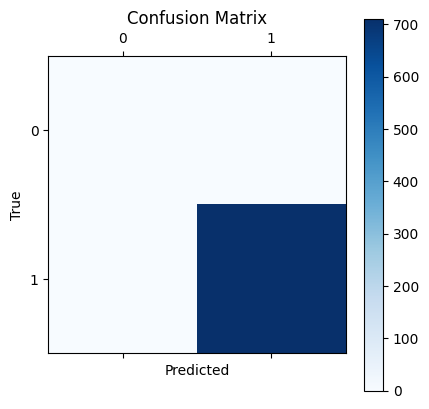

In [19]:
# Entry Point
if __name__ == "__main__":
    main("2303.16727v2.pdf")


# Test


In [ ]:
import PyPDF2
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from gtts import gTTS
from pydub import AudioSegment

# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the section labels and their corresponding indices
section_labels = ['introduction', 'methodology', 'results', 'discussion', 'references', 'captions']
section_indices = {label: idx for idx, label in enumerate(section_labels)}

# Function to classify text into sections
def classify_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_label = section_labels[torch.argmax(probs)]
    return predicted_label

# Function to extract text from PDF and classify sections
def extract_sections_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ''
        sections = {'introduction': [], 'methodology': [], 'results': [], 'discussion': []}
        for page in range(len(pdf_reader.pages)):
            page_text = pdf_reader.pages[page].extract_text()
            for paragraph in page_text.split('\n\n'):
                if paragraph.strip():
                    section_label = classify_text(paragraph)
                    if section_label in sections:
                        sections[section_label].append(paragraph)
                    text += paragraph + '\n'
    return sections, text

# Function to convert text to speech and save as MP3
def text_to_mp3(text, output_file):
    tts = gTTS(text=text, lang='en')
    mp3_data = tts.get_data()
    audio = AudioSegment(mp3_data, sample_width=2, frame_rate=44100, channels=2)
    audio.export(output_file, format='mp3')

# Main function
def main(pdf_path, output_file):
    sections, text = extract_sections_from_pdf(pdf_path)
    important_text = '\n'.join(['\n'.join(sections['introduction']),
                                '\n'.join(sections['methodology']),
                                '\n'.join(sections['results']),
                                '\n'.join(sections['discussion'])])
    text_to_mp3(important_text, output_file)

# Example usage
pdf_path = 'research_paper.pdf'
output_file = 'audio_output.mp3'
main(pdf_path, output_file)